In [1]:
import copy
from pathlib import Path

import scipy.io.wavfile as wav
import numpy as np
from sklearn import preprocessing

from python_speech_features import mfcc
from python_speech_features import delta

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

In [16]:
genres = {'reggae': 0, 'metal': 1, 'blues': 2, 'country': 3,
         'classical': 4, 'pop': 5, 'jazz': 6, 'rock': 7,
         'hiphop': 8, 'disco': 9}

#Genres
# 0: reggae
# 1: metal
# 2: blues
# 3: country
# 4: classical
# 5: pop
# 6: jazz
# 7: rock
# 8: hiphop
# 9: disco

def_rate = 22050

def readSongs(duration):
    pathlist = Path('../genres').glob('**/*.wav')
    
    song_sigs = {'reggae': [], 'metal': [], 'blues': [], 'country': [],
         'classical': [], 'pop': [], 'jazz': [], 'rock': [],
         'hiphop': [], 'disco': []}
    
    train_sigs = []
    train_labels = []
    test_sigs = []
    test_labels = []
    
    for path in pathlist:
        p = str(path)
        genre = p.split('/')[2]
        (rate, sig) = wav.read(p)
        sig = sig[:rate*duration]
        song_sigs[genre].append(sig)
    
    for key in song_sigs:
        perm = np.random.permutation(100)
        train = perm[:70]
        test = perm[70:]
        
        train_sigs.extend(np.array(song_sigs[key])[train])
        train_labels.extend(np.repeat(genres[key], 70))
        
        test_sigs.extend(np.array(song_sigs[key])[test])
        test_labels.extend(np.repeat(genres[key], 30))
        
    return train_sigs, train_labels, test_sigs, test_labels

def extractFeatures(signals, labels, duration, sample_len):
    features = []
    f_labels = []
    no_samples = int(duration/sample_len)
    part_len = int(def_rate*sample_len)
    for i in range(len(signals)):
        lab = labels[i]
        sig = signals[i]
        
        for j in range(no_samples):
            part = sig[j*part_len:(j+1)*part_len]

            mfcc_feat = mfcc(part, def_rate, nfft=551)
            d_mfcc_feat = delta(mfcc_feat, 2)
            dd_mfcc_feat = delta(d_mfcc_feat, 2)
            #Cast to single vector
            sample = np.hstack((np.hstack((mfcc_feat.flatten(), d_mfcc_feat.flatten())), dd_mfcc_feat.flatten()))
            features.append(sample)
            f_labels.append(lab)
            
    return features, f_labels

def createForest(feat, labels):
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features='sqrt')
    rf.fit(feat, labels)
    
    return rf

def getData(signals, labels, duration, sample_len):
    feat, f_labels = extractFeatures(signals, labels, duration, sample_len)
    
    scaler = preprocessing.StandardScaler().fit(feat)
    feat = scaler.transform(feat)
    
    return np.array(feat), np.array(f_labels)

def avgNSamples(a, N):
    tmp = np.cumsum(a, 0)[N-1::N]/float(N)
    tmp[1:] = tmp[1:] - tmp[:-1]
    return tmp

def songWeightedPred(rf, feat, label, no_samples):
    truth = label[::no_samples]
    pred = np.argmax(avgNSamples(rf.predict_proba(feat), no_samples), axis=1)
    return truth, pred

def validateModel(signals, labels, duration, sample_len):
    skf = StratifiedKFold(n_splits=7, shuffle=True)
    
    print('start features')
    trf, trl = getData(signals, labels, duration, sample_len)
    print('end features')
    
    no_samples = int(duration/sample_len)
    list_len = np.arange(no_samples)
    indices = np.arange(len(signals)) * no_samples
    t = np.array(list(map(lambda x: x + list_len, indices)))
    
    prec_l = []
    recall_l = []
    fscore_l = []
    prec_w = []
    recall_w = []
    fscore_w = []
    for tr_idx, te_idx in skf.split(signals, labels):
        new_tridx = t[tr_idx].flatten()
        new_teidx = t[te_idx].flatten()
        
        print('start forest')
        rf = createForest(trf[new_tridx], trl[new_tridx])
        print('end forest')
        pred = rf.predict(trf[new_teidx])
        prec, recall, fscore, sup = precision_recall_fscore_support(trl[new_teidx], pred, average='macro')
        prec_l.append(prec)
        recall_l.append(recall)
        fscore_l.append(fscore)
#         print(prec_l[-1], recall_l[-1], fscore_l[-1])
        
        truth_w, pred_w = songWeightedPred(rf, trf[new_teidx], trl[new_teidx], no_samples)
        prec, recall, fscore, sup = precision_recall_fscore_support(truth_w, pred_w, average='macro')
        prec_w.append(prec)
        recall_w.append(recall)
        fscore_w.append(fscore)
#         print(prec_w[-1], recall_w[-1], fscore_w[-1])
        
    print(np.average(prec_l), np.average(recall_l), np.average(fscore_l))
    print(np.average(prec_w), np.average(recall_w), np.average(fscore_w))

        
trs, trl, tes, tel = readSongs(28)

In [38]:
def testModel(signals, labels, duration, sample_len, train_sigs, train_labs):
    t_feat, t_labels = extractFeatures(train_sigs, train_labs, duration, sample_len)
    scaler = preprocessing.StandardScaler().fit(t_feat)
    
    feat, f_labels = extractFeatures(signals, labels, duration, sample_len)
    t_feat = scaler.transform(t_feat)
    feat = scaler.transform(feat)
    
    tar_names = list(genres.keys())
    rf = createForest(t_feat, t_labels)
    pred = rf.predict(feat)
    print(confusion_matrix(f_labels, pred))
    print(classification_report(f_labels, pred, target_names=tar_names))
    
    no_samples = int(duration/sample_len)
    tr, pr = songWeightedPred(rf, feat, f_labels, no_samples)
    print(confusion_matrix(tr, pr))
    print(classification_report(tr, pr, target_names=tar_names))
    
    return rf, scaler


In [17]:
validateModel(trs, trl, 28, 14)

start features
end features
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
0.43930167904472456 0.46499999999999997 0.42984995882917504
0.43998151505725586 0.4614285714285714 0.4249053947164301


In [18]:
validateModel(trs, trl, 28, 7)

start features
end features
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
0.45183066484538886 0.46535714285714286 0.43875544435304736
0.5140752246021173 0.5128571428571428 0.48207896816171475


In [19]:
validateModel(trs, trl, 28, 2)

start features
end features
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
0.46190131378365956 0.47775510204081634 0.4561722942435868
0.5424891742687591 0.5314285714285714 0.5042316771469683


In [20]:
validateModel(trs, trl, 28, 1)

start features
end features
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
0.46819301003542224 0.48428571428571426 0.46352940251975117
0.5865597039267524 0.5685714285714286 0.5473463199709212


In [21]:
validateModel(trs, trl, 28, 0.5)

start features
end features
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
0.4685826481640504 0.48390306122448973 0.46570990117678074
0.6131920731732762 0.5914285714285715 0.573674319835947


In [22]:
validateModel(trs, trl, 28, 0.25)

start features
end features
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
0.46702007725559 0.4843877551020408 0.4662817155957793
0.6655126817626817 0.6271428571428572 0.6069281823347935


In [23]:
validateModel(trs, trl, 28, 0.05)

start features
end features
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
start forest
end forest
0.4307696276149824 0.4522270408163265 0.4334990600453783
0.6764931434480305 0.6371428571428571 0.614582124930852


In [24]:
# PREC, RECALL, F1-SCORE
prec_sample = []
prec_w = []

recall_sample = []
recall_w = []

f1_sample = []
f1_w = []
# 28-14
prec_sample.append(0.43930167904472456)
recall_sample.append(0.46499999999999997)
f1_sample.append(0.42984995882917504)
prec_w.append(0.43998151505725586)
recall_w.append(0.4614285714285714)
f1_w.append(0.4249053947164301)

# 28-7
prec_sample.append(0.45183066484538886)
recall_sample.append(0.46535714285714286)
f1_sample.append(0.43875544435304736)
prec_w.append(0.5140752246021173)
recall_w.append(0.5128571428571428)
f1_w.append(0.48207896816171475)
  
# 28-2
prec_sample.append(0.46190131378365956)
recall_sample.append(0.47775510204081634)
f1_sample.append(0.4561722942435868)
prec_w.append(0.5424891742687591)
recall_w.append(0.5314285714285714)
f1_w.append(0.5042316771469683)
  
# 28-1
prec_sample.append(0.46819301003542224)
recall_sample.append(0.48428571428571426)
f1_sample.append(0.46352940251975117)
prec_w.append(0.5865597039267524)
recall_w.append(0.5685714285714286)
f1_w.append(0.5473463199709212)
  
# 28-0.5
prec_sample.append(0.4685826481640504)
recall_sample.append(0.48390306122448973)
f1_sample.append(0.46570990117678074)
prec_w.append(0.6131920731732762)
recall_w.append(0.5914285714285715)
f1_w.append(0.573674319835947)
  
# 28-0.25
prec_sample.append(0.46702007725559)
recall_sample.append(0.4843877551020408)
f1_sample.append(0.4662817155957793)
prec_w.append(0.6655126817626817)
recall_w.append(0.6271428571428572)
f1_w.append(0.6069281823347935)
  
# 28-0.05
prec_sample.append(0.4307696276149824)
recall_sample.append(0.4522270408163265)
f1_sample.append(0.4334990600453783)
prec_w.append(0.6764931434480305)
recall_w.append(0.6371428571428571)
f1_w.append(0.614582124930852)

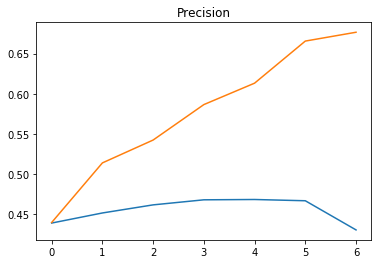

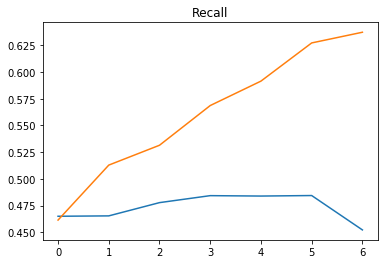

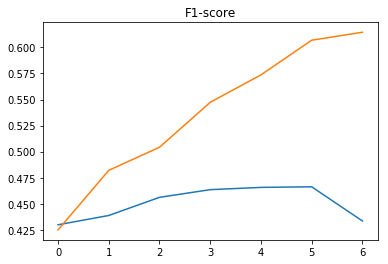

In [31]:
plt.plot(np.arange(7), prec_sample)
plt.plot(np.arange(7), prec_w)
plt.title('Precision')
plt.show()

plt.plot(np.arange(7), recall_sample)
plt.plot(np.arange(7), recall_w)
plt.title('Recall')
plt.show()

plt.plot(np.arange(7), f1_sample)
plt.plot(np.arange(7), f1_w)
plt.title('F1-score')
plt.show()

In [39]:
final_rf, final_scaler = testModel(tes, tel, 28, 0.05, trs, trl)

[[ 6284   305  1140  1313  1110  1971  1029   540  2188   920]
 [  294 12045   640   435    38   482   573   822   864   607]
 [  855  2617  6992  1465   706     2  1423  1557   507   676]
 [  989   398  1853  5694   850  2358  1923  1015   431  1289]
 [  215    16   195   362 14222   174  1234   207    24   151]
 [  766    56    36   601   143 12397   311   211  1473   806]
 [  869   330  1400  1414  2215  1349  7945   753   186   339]
 [  867  2050  2066  1913   497  2405  1066  2533   832  2571]
 [ 2179  1532   557   613   305  2259   534   703  6518  1600]
 [ 1256  1761   917  1046   455  2788   860  1464  1532  4721]]
             precision    recall  f1-score   support

     reggae       0.43      0.37      0.40     16800
      metal       0.57      0.72      0.64     16800
      blues       0.44      0.42      0.43     16800
    country       0.38      0.34      0.36     16800
  classical       0.69      0.85      0.76     16800
        pop       0.47      0.74      0.58     168